In [1]:
import dlc_bci as bci

import os

import torch
import numpy as np
from matplotlib.pylab import plt

from models import *
from callbacks import keep_best_model, store_best_model

from types import SimpleNamespace 

import torch 
from torch import optim
from torch import nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# def create_model():
#     torch.manual_seed(1)
    
#     return nn.Sequential(
#         nn.BatchNorm1d(28),
#             nn.Conv1d(28, 32, kernel_size=5, padding=2),
# #             nn.ReLU(),
#             nn.Dropout(0.0),
        
# #             nn.Conv1d(32, 32, kernel_size=5, padding=2),
# #             nn.ELU(),
# #             nn.Dropout(0.1),

# #             nn.Conv1d(32, 32, kernel_size=5, padding=2),
# #             nn.Tanh(),
# #             nn.Dropout(0.1),
#             nn.MaxPool1d(2, padding=1),
#             nn.Conv1d(32, 32, kernel_size=5, padding=2),
#             nn.MaxPool1d(2, padding=1),
#             nn.ELU(),
#             nn.Dropout(0.0),
#     )
# b = 0
# batch_size = 20
# # seed not working ...
# torch.manual_seed(1)
# # model2 = create_model()
# model2 = CNN_1D_MaxPool(**params)
# model2.to(device)

# output = model2(X_tr[b : b+batch_size])
# loss = model2.criterion(output, y_tr[b : b+batch_size])
# model2.zero_grad()
# loss.backward()
# model2.optimizer.step()

# torch.manual_seed(1)
# # model1 = create_model()
# model1 = CNN_1D_MaxPool(**params)
# model1.to(device)

# output = model1(X_tr[b : b+batch_size])
# loss = model1.criterion(output, y_tr[b : b+batch_size])
# model1.zero_grad()
# loss.backward()
# model1.optimizer.step()

# print("loss:", loss == loss)
# p1 = model1.parameters()
# p2 = model2.parameters()
# for p in p1:
#     print((p == next(p2)).all())
# (model1(X_tr[:1]) == model2(X_tr[:1])).all()

In [ ]:
# grid_search_on=[
#         ("nb_layers", list(range(1, 7))),
#         ("nb_hidden", [np.asscalar(n) for n in np.arange(40, 201, 40)]),
#         ("activation", [nn.ReLU, nn.Tanh, nn.ELU]),
#         ("weight_decay", [0] + [np.asscalar(wd) for wd in np.logspace(-6, -2, 5, base=np.e)]),
#         ("dropout", [np.asscalar(d) for d in np.linspace(0, 0.30, 4)]),
#         ("optimizer", [optim.Adam, optim.Adadelta, optim.Adamax]),
#         ("nb_layers", list(range(1, 7)))
#     ]

### Load data

In [2]:
one_khz=False

train = SimpleNamespace()
train.X, train.y = bci.load(root='./data_bci', one_khz=one_khz)
print(str(type(train.X)), train.X.size())
print(str(type(train.y)), train.y.size())

test = SimpleNamespace()
test.X, test.y = bci.load(root='./data_bci', train=False, one_khz=one_khz)
print(str(type(test.X)), test.X.size())
print(str(type(test.y)), test.y.size())

<class 'torch.Tensor'> torch.Size([316, 28, 50])
<class 'torch.Tensor'> torch.Size([316])
<class 'torch.Tensor'> torch.Size([100, 28, 50])
<class 'torch.Tensor'> torch.Size([100])


In [3]:
def load_best_params_and_scores(model):
    model_path =  model().dir_path
    
    # load best params
    params = torch.load(model_path + "/cross_validation" + "/best_params_")

    # load cross validation scores
    scores = torch.load(model_path + "/cross_validation/scores/nb_layers")
    crossval_scores = scores["va_scores"][params["nb_layers"]-1]

    return params, crossval_scores

### Train the model on the best parameters and compute the test accuracy

In [4]:
cross_val_scores = {}

- `CNN2D_MaxPool`

In [5]:
params, crossval_scores = load_best_params_and_scores(CNN2D_MaxPool)
cross_val_scores["2D CNN"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ReLU,
  'dropout': 0.0,
  'nb_hidden': 40,
  'nb_layers': 3,
  'optimizer': torch.optim.adadelta.Adadelta,
  'weight_decay': 0},
 [0.703125,
  0.7619047619047619,
  0.8253968253968254,
  0.7936507936507936,
  0.7142857142857143])

In [6]:
X_tr, y_tr = CNN2D_MaxPool.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN2D_MaxPool.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN2D_MaxPool(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=30, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.69


- `CNN_1D_MaxPool`

In [11]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_MaxPool)
cross_val_scores["1D CNN"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ELU,
  'dropout': 0.09999999999999999,
  'nb_hidden': 40,
  'nb_layers': 4,
  'optimizer': torch.optim.adamax.Adamax,
  'weight_decay': 0.0024787521766663594},
 [0.71875,
  0.7619047619047619,
  0.7777777777777778,
  0.8095238095238095,
  0.873015873015873])

In [12]:
X_tr, y_tr = CNN_1D_MaxPool.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_MaxPool.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_MaxPool(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=50, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.72


- `CNN_1D_BatchNorm`

In [13]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm)
cross_val_scores["1D CNN + Batch norm"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ELU,
  'dropout': 0.3,
  'nb_hidden': 160,
  'nb_layers': 5,
  'optimizer': torch.optim.adamax.Adamax,
  'weight_decay': 0.0024787521766663594},
 [0.734375,
  0.7936507936507936,
  0.8571428571428571,
  0.7777777777777778,
  0.8253968253968254])

In [14]:
X_tr, y_tr = CNN_1D_BatchNorm.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=100, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.78


- `CNN_1D_BatchNorm_Dial`

In [15]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm_Dial)
cross_val_scores["1D CNN dialated + Batch norm"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ELU,
  'dropout': 0.09999999999999999,
  'nb_hidden': 40,
  'nb_layers': 1,
  'optimizer': torch.optim.adadelta.Adadelta,
  'weight_decay': 0.1353352832366127},
 [0.671875,
  0.746031746031746,
  0.873015873015873,
  0.8095238095238095,
  0.7619047619047619])

In [16]:
X_tr, y_tr = CNN_1D_BatchNorm_Dial.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm_Dial.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=60, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.74


- `CNN_1D_Residual`

In [17]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_Residual)
cross_val_scores["1D CNN residual"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.Tanh,
  'dropout': 0.19999999999999998,
  'nb_hidden': 120,
  'nb_layers': 6,
  'optimizer': torch.optim.adamax.Adamax,
  'weight_decay': 0.006737946999085469},
 [0.8125,
  0.6984126984126984,
  0.7777777777777778,
  0.7936507936507936,
  0.6349206349206349])

In [18]:
X_tr, y_tr = CNN_1D_Residual.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_Residual.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_Residual(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=50, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.72


### Boxplot with the scores obtained with cross validation

In [19]:
for model_name in cross_val_scores:
    print(model_name + ". Accuracy:", np.mean(cross_val_scores[model_name]), "+-",  np.std(cross_val_scores[model_name]))

2D CNN. Accuracy: 0.759672619048 +- 0.0463395607557
1D CNN. Accuracy: 0.788194444444 +- 0.0515204848119
1D CNN + Batch norm. Accuracy: 0.797668650794 +- 0.0417705856407
1D CNN dialated + Batch norm. Accuracy: 0.772470238095 +- 0.0669513508966
1D CNN residual. Accuracy: 0.743452380952 +- 0.0667433893367


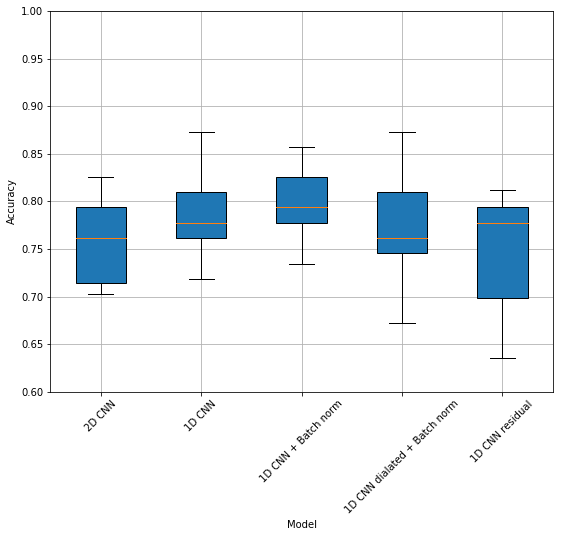

In [20]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()

model_names = []
model_scores = []
for model_name in cross_val_scores:
    model_names.append(model_name)
    model_scores.append(cross_val_scores[model_name])

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
_ = ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0.6, 1)

plt.savefig("img/cross_val_scores")

### Box plot with 

### Plot the train and test losses for `CNN_1D_BatchNorm`

In [30]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm)

X_tr, y_tr = CNN_1D_BatchNorm.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=60, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.79


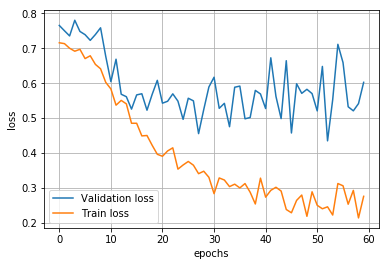

In [31]:
epochs = list(range(len(model.history.test_losses)))
plt.plot(epochs, model.history.test_losses, label='Validation loss')
plt.plot(epochs, model.history.train_losses, label='Train loss')
plt.grid()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.savefig("img/train_test_losses")

### Show train loss with different optimizers

In [27]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm)

X_tr, y_tr = CNN_1D_BatchNorm.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

# remove regularitations (we are only interested in seeing how well the train loss is optimized)
params['weight_decay'] = 0
params['dropout'] = 0
params

{'activation': torch.nn.modules.activation.ELU,
 'dropout': 0,
 'nb_hidden': 160,
 'nb_layers': 5,
 'optimizer': torch.optim.adamax.Adamax,
 'weight_decay': 0}

In [28]:
# choose optimizer, train the network, save the train losses. Repeat for every optimizer
train_losses = {}

print("Training with Adam...")
params['optimizer'] = optim.Adam
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adam"] = model.history.train_losses

print("Training with Adadelta...")
# params['optimizer'] = lambda params, weight_decay=0: optim.Adadelta(params, weight_decay=0, lr=2)
params['optimizer'] = optim.Adadelta
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adadelta"] = model.history.train_losses

print("Training with Adamax...")
params['optimizer'] = optim.Adamax
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adamax"] = model.history.train_losses

Training with Adam...


/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Training with Adadelta...
Training with Adamax...


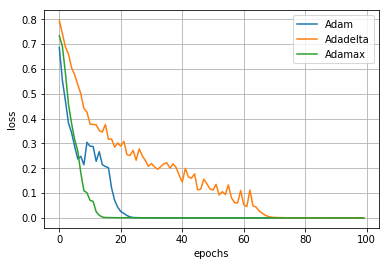

In [29]:
epochs = list(range(len(train_losses["Adam"])))
plt.plot(epochs, train_losses["Adam"], label='Adam')
plt.plot(epochs, train_losses["Adadelta"], label='Adadelta')
plt.plot(epochs, train_losses["Adamax"], label='Adamax')
plt.grid()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.savefig("img/optimizers")